In [82]:
#loading libraries
import pandas as pd
import string
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.ensemble import forest 
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
import statistics as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from skopt import BayesSearchCV



nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


# !pip install scikit-optimize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# reading the data  

In [83]:
#reading the data            
df = pd.read_csv("train.csv")


#dummy variables
id = df["id"]
location = df["location"]
keyword = df["keyword"]

# **Data Preprocessing**

**renaming the text column**

In [84]:
df = df.rename(columns={"text":"tweet"})
df["original tweet"] = df["tweet"]
print(df)

         id keyword  ... target                                     original tweet
0         1     NaN  ...      1  Our Deeds are the Reason of this #earthquake M...
1         4     NaN  ...      1             Forest fire near La Ronge Sask. Canada
2         5     NaN  ...      1  All residents asked to 'shelter in place' are ...
3         6     NaN  ...      1  13,000 people receive #wildfires evacuation or...
4         7     NaN  ...      1  Just got sent this photo from Ruby #Alaska as ...
...     ...     ...  ...    ...                                                ...
7608  10869     NaN  ...      1  Two giant cranes holding a bridge collapse int...
7609  10870     NaN  ...      1  @aria_ahrary @TheTawniest The out of control w...
7610  10871     NaN  ...      1  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611  10872     NaN  ...      1  Police investigating after an e-bike collided ...
7612  10873     NaN  ...      1  The Latest: More Homes Razed by Northern Calif...

[76

***Data Cleaning***

**Removing irrelevant features**

In [85]:
#removing irrelevant features
df = df.drop(columns=["id","location","keyword"],axis=1)
print(df)

                                                  tweet  ...                                     original tweet
0     Our Deeds are the Reason of this #earthquake M...  ...  Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada  ...             Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...  ...  All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...  ...  13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...  ...  Just got sent this photo from Ruby #Alaska as ...
...                                                 ...  ...                                                ...
7608  Two giant cranes holding a bridge collapse int...  ...  Two giant cranes holding a bridge collapse int...
7609  @aria_ahrary @TheTawniest The out of control w...  ...  @aria_ahrary @TheTawniest The out of contr

**Checking for missing values**

In [86]:
#Dropping variables that has more than 60 percent missing values

#Checking the percentage missing values by columns
missing_column = (df.isna().sum()/len(df))*100
print(missing_column)



tweet             0.0
target            0.0
original tweet    0.0
dtype: float64


**Checking for duplicate values**

In [87]:
duplicate = df.duplicated().sum()
print(duplicate)#we can see that there are duplicates values
 

92


**dropping duplicates**

In [88]:
df = df.drop_duplicates()

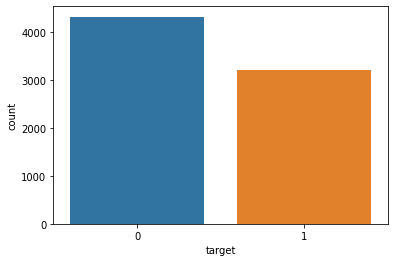

In [89]:
sns.countplot(df["target"])
#We can see the target column is balanced.

***Cleaning the tweet column***

**Removing Hyper Links**

By observing the data we can see that some text contains external links ("http://"..) which are irrelevant

In [90]:
df["tweet"] = df['tweet'].str.replace('http\S+|www.\S+', '', case=False)

print(df)

                                                  tweet  ...                                     original tweet
0     Our Deeds are the Reason of this #earthquake M...  ...  Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada  ...             Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...  ...  All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...  ...  13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...  ...  Just got sent this photo from Ruby #Alaska as ...
...                                                 ...  ...                                                ...
7604  #WorldNews Fallen powerlines on G:link tram: U...  ...  #WorldNews Fallen powerlines on G:link tram: U...
7605  on the flip side I'm at Walmart and there is a...  ...  on the flip side I'm at Walmart and there 

**Removing Punctuation And Changing The Special Characters To The Usual Alphabet Letters** 

Raw data contain  punctuation,Hyper Link,special character.These value can hamper the performance of model so before applying any text Vectorization first we need to convert raw data into meaningful data which is also called as text preprocessing .

In [91]:
#Removing punctuation
df["tweet"] = df['tweet'].str.replace('[{}]'.format(string.punctuation), '')


#Changing the special characters to the usual alphabet letters
df['tweet'] = df["tweet"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print(df["tweet"])



0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7604    WorldNews Fallen powerlines on Glink tram UPDA...
7605    on the flip side Im at Walmart and there is a ...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest More Homes Razed by Northern Califo...
Name: tweet, Length: 7521, dtype: object


**Removing numbers from dataframe**

Removing numbers from the text like “1,2,3,4,5…” We will remove numbers because numbers doesn’t give much importance to get the main words.

In [92]:
df['tweet'] = df['tweet'].str.replace('\d+', '')

**Tokenizing data**

We use the method word_tokenize() to split a sentence into words. The output of word tokenization can be converted to DataFrame for better text understanding in machine learning applications. It can also be provided as input for further text cleaning steps such as  numeric character removal or stop words removal. Machine learning models need numeric data to be trained and make a prediction. Word tokenization becomes a crucial part of the text (string) to numeric data conversion.

In [93]:
df["tweet"] = [word_tokenize(word) for word in df["tweet"]]
print(df["tweet"])


0       [Our, Deeds, are, the, Reason, of, this, earth...
1           [Forest, fire, near, La, Ronge, Sask, Canada]
2       [All, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [Just, got, sent, this, photo, from, Ruby, Ala...
                              ...                        
7604    [WorldNews, Fallen, powerlines, on, Glink, tra...
7605    [on, the, flip, side, Im, at, Walmart, and, th...
7606    [Suicide, bomber, kills, in, Saudi, security, ...
7608    [Two, giant, cranes, holding, a, bridge, colla...
7612    [The, Latest, More, Homes, Razed, by, Northern...
Name: tweet, Length: 7521, dtype: object


**Conveting text to Lower Case**

The model might treat a word which is in the beginning of a sentence with a capital letter different from the same word which appears later in the sentence but without any capital latter. This might lead to decline in the accuracy. Whereas lowering the words would be a better trade off.So that 'A' letter differ from 'a' letter in computer

In [94]:
df["tweet"] = [[word.lower() for word in words ] for words in df["tweet"]]
print(df)

                                                  tweet  ...                                     original tweet
0     [our, deeds, are, the, reason, of, this, earth...  ...  Our Deeds are the Reason of this #earthquake M...
1         [forest, fire, near, la, ronge, sask, canada]  ...             Forest fire near La Ronge Sask. Canada
2     [all, residents, asked, to, shelter, in, place...  ...  All residents asked to 'shelter in place' are ...
3     [people, receive, wildfires, evacuation, order...  ...  13,000 people receive #wildfires evacuation or...
4     [just, got, sent, this, photo, from, ruby, ala...  ...  Just got sent this photo from Ruby #Alaska as ...
...                                                 ...  ...                                                ...
7604  [worldnews, fallen, powerlines, on, glink, tra...  ...  #WorldNews Fallen powerlines on G:link tram: U...
7605  [on, the, flip, side, im, at, walmart, and, th...  ...  on the flip side I'm at Walmart and there 

**Removing stop words from texts**

Removing stopwords can potentially help improve the performance as 
there are fewer and only meaningful tokens left.
Thus, it could increase classification accuracy.

In [95]:
stop_words = stopwords.words('english')

df["tweet"] = [[words for words in word if words not in stop_words] for word in df["tweet"]]
print(df["tweet"])


0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7604    [worldnews, fallen, powerlines, glink, tram, u...
7605    [flip, side, im, walmart, bomb, everyone, evac...
7606    [suicide, bomber, kills, saudi, security, site...
7608    [two, giant, cranes, holding, bridge, collapse...
7612    [latest, homes, razed, northern, california, w...
Name: tweet, Length: 7521, dtype: object


**Lematization**

Lemmatization usually aims to remove word endings. It helps in returning the base or dictionary form of a word, which is known as the lemma.

<!-- congrats yey you found the easter egg (hahaha) 

text me to claim your reward -->

In [96]:
lem = nltk.WordNetLemmatizer()
df["tweet"] = [[lem.lemmatize(lema,"v") for lema in i]for i in df["tweet"]]



# Modelling

**Declaring Inpendent and Dependent Variable**


In [97]:
x = df["tweet"]
y = df["target"]

**Splitting the data**

Now the data is clean we will be Spltting the dataframe into training and testing sample of 80% and 20% respectively.


In [98]:
x_train,x_test,y_train,y_test = train_test_split = train_test_split(x,y, test_size=0.2, random_state=0)
print(x_train.shape)
print(x_test.shape)

(6016,)
(1505,)


**Converting text to numeric**

We cannot work with text directly when using machine learning algorithms. Instead, we need to convert the text to numbers.
Computers don’t understand text and only understand and process numbers. 

When applying TfidfVectorizer,CountVectorization etc on text they expect an array of string that has not been tokenized. So if you pass him an array of arrays of tokenz, it crashes.We will  be passing a tokenized text to the vectorizer, to deal with this We need to pass a dummy fuction to  tokenizer and preprocessor parameter.



Count vectorization

In [99]:
# # Creating a dummy fuction so it can be passed to the  (tokenizer and preprocessor) parameter
# def dummy(doc):
#     return doc

# cv = CountVectorizer(
#         tokenizer=dummy,
#         preprocessor=dummy,
#         min_df = 0.000167
        
#     )  

# x_train = cv.fit_transform(x_train)

# x_test =  cv.transform(x_test)



Tfidfvectorizer

In [100]:
def dummy(doc):
    return doc

tfidf = TfidfVectorizer(#stop_words='english',
         tokenizer=dummy,
         preprocessor=dummy,
         min_df = 0.000167

)

x_train = tfidf.fit_transform(x_train)

x_test =  tfidf.transform(x_test)





Using Cross Validation to find the algorithm that gives the best performance

In [101]:
xg = xgb.XGBClassifier()
fo =  forest.RandomForestClassifier()
tr = tree.DecisionTreeClassifier()
lo = linear_model.LogisticRegression()
sv = svm.SVC()

xgb_score = cross_val_score(xg,x_train,y_train,cv=5)
ran_score = cross_val_score(fo,x_train,y_train,cv=5)
dtree_score = cross_val_score(tr,x_train,y_train,cv=5)
log_score = cross_val_score(lo,x_train,y_train,cv=5)
svm_score = cross_val_score(sv,x_train,y_train,cv=5)

# This Dataframe outputs the average score for each algorithms
df_score = pd.DataFrame({"model":["xgboost","RandomForestClassifier","DecisionTreeClassifier","LogisticRegression","Support vector machine"],"score":[stats.mean(xgb_score),stats.mean(ran_score),stats.mean(dtree_score),stats.mean(log_score),stats.mean(svm_score)]})
print(df_score)
# We can see that Support vector machine classifier gave the best score


                    model     score
0                 xgboost  0.734041
1  RandomForestClassifier  0.785737
2  DecisionTreeClassifier  0.730050
3      LogisticRegression  0.797705
4  Support vector machine  0.799368


**Hyperparameter Tuning Using Using BayesSearchCV**

Finding the hyperparameter values of a learning algorithm that produces the best result

In [102]:
#Checking initial model score
initial_model = svm.SVC()
initial_model = initial_model.fit(x_train,y_train)
original_score = initial_model.score(x_test,y_test)
print(f'Original Score = {original_score}')

# Count vectorization score = Score = 0.7906976744186046
# Tfidf score = Score = 0.7933554817275748

#We see Tfidf gives the best score..so tfidf will be used for vectorization


Original Score = 0.7933554817275748


Optimizing parameters

In [103]:
# Finding the best parameter
# optimize_model  = svm.SVC()
# param = {'C': [0.1,1, 10, 52,100], 'gamma': ('auto','scale'),'kernel': ['linear','rbf', 'poly', 'sigmoid']}
# search = BayesSearchCV(optimize_model,param,scoring="accuracy")
# search = search.fit(x_train,y_train)
# print(search.best_params_)

#best_param = C=1.0,gamma='scale',kernel='rbf'



Optimized model

In [104]:
model = svm.SVC(C=1.0,gamma=1.0,kernel='rbf')
model = model.fit(x_train,y_train)
score = model.score(x_test,y_test)
print(f'model Score = {score}')

model Score = 0.7933554817275748


# Predicting which Tweets are about real disasters and which ones are not

**Reading the data**

In [105]:
test = pd.read_csv("clean_test.csv")
#dummy variables
tweet_id =  test["id"]
tweets = test["tweet"]
print(tweets.shape)

(3263,)


**converting tweets to numeric using Tfidf vectorizer**

In [106]:
tweets = tfidf.transform(tweets)

**Predicting test data**

In [107]:
pred = model.predict(tweets)
new_df = {"id":tweet_id,"target":pred}
new_df = pd.DataFrame(new_df)
print(new_df)

         id  target
0         0       0
1         2       1
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       1
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]


saving to csv

In [108]:
disaster_pred = new_df.to_csv("disaster_pred.csv",index = False)
print(disaster_pred)

None
